In [1]:
!git clone https://github.com/KairoSagewing5/DeepLearning2023.git

Cloning into 'DeepLearning2023'...
remote: Enumerating objects: 44982, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 44982 (delta 2), reused 8 (delta 2), pack-reused 44973
Receiving objects: 100% (44982/44982), 1.64 GiB | 16.79 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (44967/44967), done.


In [2]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 76.2 MB/s eta 0:00:00


In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'CARGO_PLANE', 1: 'HELICOPTER', 2: 'SMALL_CAR', 3: 'BUS', 4: 'TRUCK', 5: 'MOTORBOAT', 6: 'FISHING_VESSEL', 7: 'DUMP_TRUCK', 8: 'EXCAVATOR', 9: 'BUILDING', 10: 'STORAGE_TANK', 11: 'SHIPPING_CONTAINER'}

In [5]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category = rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle = False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a CNN to deal with the “xview_recognition” classification task.

In [7]:
import json

# Load database
json_file = 'DeepLearning2023/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [8]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'CARGO_PLANE': 635, 'HELICOPTER': 70, 'SMALL_CAR': 11675, 'BUS': 4017, 'TRUCK': 5836, 'MOTORBOAT': 571, 'FISHING_VESSEL': 457, 'DUMP_TRUCK': 1108, 'EXCAVATOR': 741, 'BUILDING': 13011, 'STORAGE_TANK': 1249, 'SHIPPING_CONTAINER': 816}


In [9]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [10]:
# Load architecture
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, \
                        ZeroPadding2D, Conv2D, BatchNormalization, Add, AveragePooling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal

"""
def relu_batch_adder(inputs):
    out = Activation('gelu')(inputs)
    out = BatchNormalization()(out)
    return out

def residual(x, downsample, filters, kernel_size = 3):
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_batch_adder(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_batch_adder(out)
    return out
    """
def residual_block(x, number_of_filters, match_filter_size=False):
   
    #Residual block with
    
    # Retrieve initializer
    initializer = HeNormal()

    # Create skip connection
    x_skip = x

    # Perform the original mapping
    if match_filter_size:
        x = Conv2D(number_of_filters, kernel_size=(3, 3), strides=(2,2),\
            kernel_initializer=initializer, padding="same")(x_skip)
    else:
        x = Conv2D(number_of_filters, kernel_size=(3, 3), strides=(1,1),\
            kernel_initializer=initializer, padding="same")(x_skip)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = Conv2D(number_of_filters, kernel_size=(3, 3),\
        kernel_initializer=initializer, padding="same")(x)
    x = BatchNormalization(axis=3)(x)

    if match_filter_size:
        x_skip = Conv2D(number_of_filters, kernel_size=(1,1),\
            kernel_initializer=initializer, strides=(2,2))(x_skip)
    
    # Add the skip connection to the regular mapping
    x = Add()([x, x_skip])

    # Nonlinearly activate the result
    x = Activation("relu")(x)

    # Return the result
    return x


def ResidualBlocks(x):
    """
        Set up the residual blocks.
    """

    # Set initial filter size
    filter_size = 16

    # Paper: "Then we use a stack of 6n layers (...)
    #    with 2n layers for each feature map size."
    # 6n/2n = 3, so there are always 3 groups.
    for layer_group in range(3):

        # Each block in our code has 2 weighted layers,
        # and each group has 2n such blocks,
        # so 2n/2 = n blocks per group.
        for block in range(3):

            # Perform filter size increase at every
            # first layer in the 2nd block onwards.
            # Apply Conv block for projecting the skip
            # connection.
            if layer_group > 0 and block == 0:
                filter_size *= 2
                x = residual_block(x, filter_size, match_filter_size=True)
            else:
                x = residual_block(x, filter_size)

    # Return final layer
    return x

def model_base(shp):
    """
        Base structure of the model, with residual blocks
        attached.
    """
    # Get number of classes from model configuration
    initializer = HeNormal()

    # Define model structure
    # logits are returned because Softmax is pushed to loss function.
    inputs = Input(shape = shp)
    x = Conv2D(16, kernel_size=(3,3),\
        strides=(1,1), kernel_initializer=initializer, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = ResidualBlocks(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(12, kernel_initializer = initializer)(x)

    return inputs, outputs

In [11]:
print('Load model')
"""
inputs = Input(shape=(224, 224, 3))
num_filters = 64

t = BatchNormalization()(inputs)
t = Conv2D(kernel_size=3,
           strides=1,
           filters=num_filters,
           padding="same")(t)
t = relu_batch_adder(t)

num_blocks_list = [2, 5, 5, 2]
for i in range(len(num_blocks_list)):
    num_blocks = num_blocks_list[i]
    for j in range(num_blocks):
        t = residual(t, downsample=(j==0 and i!=0), filters=num_filters)
    num_filters *= 2

t = AveragePooling2D(4)(t)
t = Flatten()(t)
outputs = Dense(12, activation='softmax')(t)
"""
def build_model(input_shape, num_classes=12):
    inputs, outputs = model_base(input_shape)
    outputs = Activation("softmax")(outputs)
    model = Model(inputs=inputs, outputs=outputs)

    return model


input_shape = (224, 224, 3)

model = build_model(input_shape, num_classes=12)
model.summary()
"""
inputs, outputs = model_base((224, 224, 3))

model = Model(inputs, outputs)
model.summary()
"""

Load model


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

'\ninputs, outputs = model_base((224, 224, 3))\n\nmodel = Model(inputs, outputs)\nmodel.summary()\n'

In [12]:
from keras.optimizers import Adam

# Learning rate is changed to 0.001
model.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model_resnet_1.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [15]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 32
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [16]:
import math
import numpy as np
print('Training model')
epochs = 20
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/20
1131/1131 [==============================] - ETA: 0s - loss: 1.2835 - accuracy: 0.5881
Epoch 1: val_accuracy improved from -inf to 0.55362, saving model to model_resnet_1.hdf5
1131/1131 [==============================] - 160s 120ms/step - loss: 1.2835 - accuracy: 0.5881 - val_loss: 1.6140 - val_accuracy: 0.5536 - lr: 0.0010
Epoch 2/20
1130/1131 [============================>.] - ETA: 0s - loss: 1.1080 - accuracy: 0.6332
Epoch 2: val_accuracy improved from 0.55362 to 0.62478, saving model to model_resnet_1.hdf5
1131/1131 [==============================] - 127s 112ms/step - loss: 1.1081 - accuracy: 0.6332 - val_loss: 1.1941 - val_accuracy: 0.6248 - lr: 0.0010
Epoch 3/20
1130/1131 [============================>.] - ETA: 0s - loss: 1.0557 - accuracy: 0.6458
Epoch 3: val_accuracy improved from 0.62478 to 0.63847, saving model to model_resnet_1.hdf5
1131/1131 [==============================] - 125s 111ms/step - loss: 1.0557 - accuracy: 0.6458 - val_loss: 1.1591 - va

#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [18]:
import json
# Load database
json_file = 'DeepLearning2023/xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [19]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    image.add_object(obj)
    anns.append(image)

In [20]:
import numpy as np

# model.load_weights('model_resnet_1.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 [==============================] - 0s 22ms/step


<ipython-input-6-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


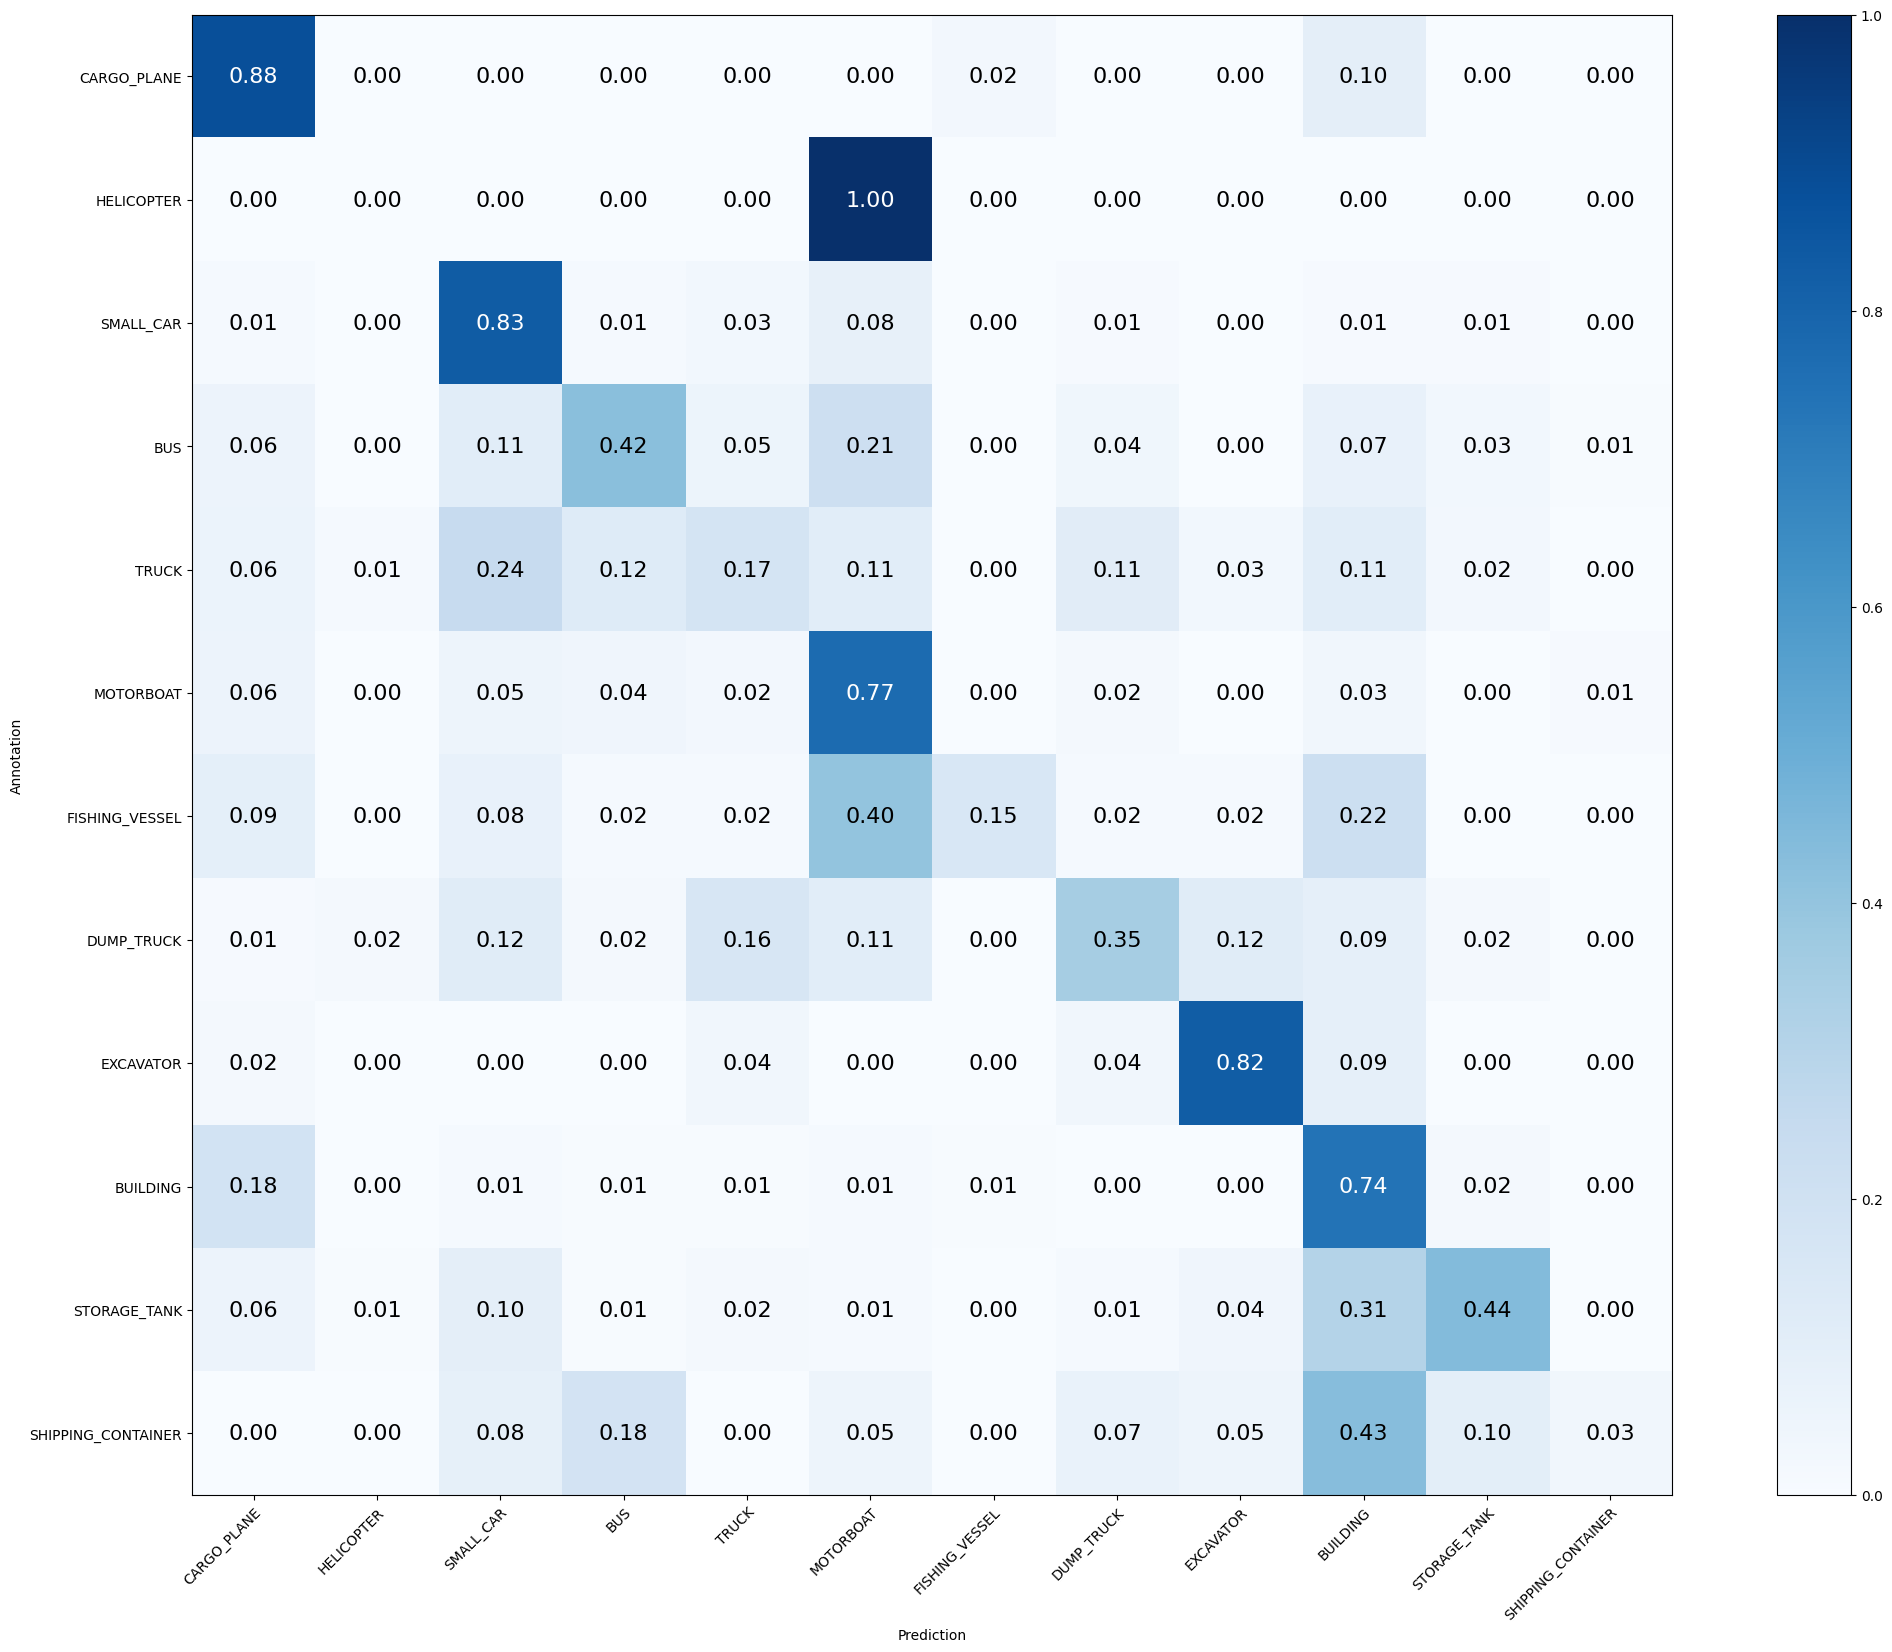

In [21]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

# Note. this notebook was run two times, and the first time it actually classified almost instances as small cars instead of buildings

In [22]:
import numpy as np

####RESULTS FROM THE FIRST RUN (CARS)

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 62.382%
Mean Recall: 46.795%
Mean Precision: 40.772%
> CARGO_PLANE: Recall: 87.952% Precision: 15.598% Specificity: 91.585% Dice: 26.497%
> HELICOPTER: Recall: 0.000% Precision: 0.000% Specificity: 99.665% Dice: 0.000%
> SMALL_CAR: Recall: 83.056% Precision: 80.756% Specificity: 91.459% Dice: 81.890%
> BUS: Recall: 42.478% Precision: 59.077% Specificity: 96.925% Dice: 49.421%
> TRUCK: Recall: 17.266% Precision: 53.812% Specificity: 97.477% Dice: 26.144%
> MOTORBOAT: Recall: 77.049% Precision: 21.124% Specificity: 92.460% Dice: 33.157%
> FISHING_VESSEL: Recall: 15.385% Precision: 43.478% Specificity: 99.724% Dice: 22.727%
> DUMP_TRUCK: Recall: 34.821% Precision: 23.780% Specificity: 97.320% Dice: 28.261%
> EXCAVATOR: Recall: 82.456% Precision: 47.959% Specificity: 98.919% Dice: 60.645%
> BUILDING: Recall: 73.997% Precision: 82.959% Specificity: 92.727% Dice: 78.222%
> STORAGE_TANK: Recall: 43.750% Precision: 44.056% Specificity: 98.273% Dice: 43.902%
> SHIPPING_CONTAINER:

In [23]:
import numpy as np

####RESULTS FROM THE SECOND RUN (BUIlDINGS)

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 62.382%
Mean Recall: 46.795%
Mean Precision: 40.772%
> CARGO_PLANE: Recall: 87.952% Precision: 15.598% Specificity: 91.585% Dice: 26.497%
> HELICOPTER: Recall: 0.000% Precision: 0.000% Specificity: 99.665% Dice: 0.000%
> SMALL_CAR: Recall: 83.056% Precision: 80.756% Specificity: 91.459% Dice: 81.890%
> BUS: Recall: 42.478% Precision: 59.077% Specificity: 96.925% Dice: 49.421%
> TRUCK: Recall: 17.266% Precision: 53.812% Specificity: 97.477% Dice: 26.144%
> MOTORBOAT: Recall: 77.049% Precision: 21.124% Specificity: 92.460% Dice: 33.157%
> FISHING_VESSEL: Recall: 15.385% Precision: 43.478% Specificity: 99.724% Dice: 22.727%
> DUMP_TRUCK: Recall: 34.821% Precision: 23.780% Specificity: 97.320% Dice: 28.261%
> EXCAVATOR: Recall: 82.456% Precision: 47.959% Specificity: 98.919% Dice: 60.645%
> BUILDING: Recall: 73.997% Precision: 82.959% Specificity: 92.727% Dice: 78.222%
> STORAGE_TANK: Recall: 43.750% Precision: 44.056% Specificity: 98.273% Dice: 43.902%
> SHIPPING_CONTAINER:

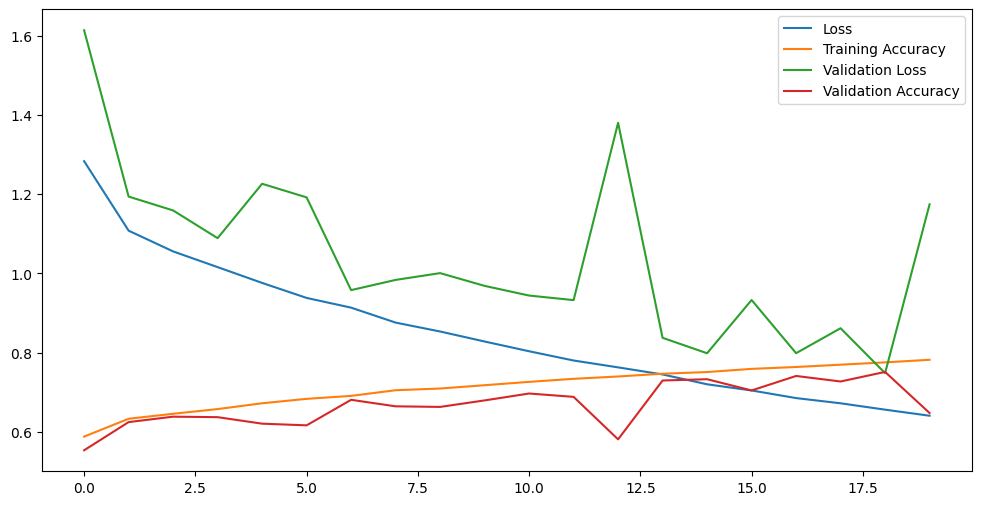

In [24]:
plt.figure(figsize=(12, 6))

plt.plot(h.history['loss'], label='Loss')
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')

plt.legend()
plt.show()